<a href="https://colab.research.google.com/github/gouthamans14/deeplearning-tesnorflow/blob/main/TransferLearning/TransferLearning_FineTuning_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning usinf TensorFlow - Part2 : Fine Tuning

In [3]:
!nvidia-smi

Sun Jul  2 09:59:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### Creating helper functions

In [5]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [6]:
!wget https://raw.githubusercontent.com/gouthamans14/deeplearning-tesnorflow/main/extras/helper_functions.py

--2023-07-02 09:59:29--  https://raw.githubusercontent.com/gouthamans14/deeplearning-tesnorflow/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-02 09:59:29 (93.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [7]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

We are goinf to use pretrained models within 'tf.keras.applications'

### Getting the Data

In [8]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


--2023-07-02 09:59:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.128, 142.251.6.128, 108.177.112.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   248MB/s    in 0.6s    

2023-07-02 09:59:31 (248 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [9]:
unzip_data("10_food_classes_10_percent.zip")

In [10]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [11]:
train_dir ="10_food_classes_10_percent/train/"
test_dir ="10_food_classes_10_percent/test/"

### Preprocessing

Now we've got some image data, we need a way of loading it into a TensorFlow compatible format.

Previously, we've used the ImageDataGenerator class. And while this works well and is still very commonly used, this time we're going to use the image_data_from_directory function.

It works much the same way as ImageDataGenerator's flow_from_directory method meaning your images need to be in the following file format:

One of the main benefits of using tf.keras.prepreprocessing.image_dataset_from_directory() rather than ImageDataGenerator is that it creates a tf.data.Dataset object rather than a generator. The main advantage of this is the tf.data.Dataset API is much more efficient (faster) than the ImageDataGenerator API which is paramount for larger datasets.

In [12]:
import tensorflow as tf

IMG_SIZE = (224,224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                           image_size=IMG_SIZE,
                                                           label_mode="categorical",
                                                           batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory =test_dir,
                                                          image_size=IMG_SIZE,
                                                          label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [13]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [14]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [15]:
for images, labels in train_data.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.90969391e+02 9.79693909e+01 2.89693871e+01]
   [1.91831635e+02 9.88316345e+01 2.98316326e+01]
   [1.91785721e+02 9.87857132e+01 2.97857132e+01]
   ...
   [2.15780670e+02 2.13994934e+02 2.27209198e+02]
   [2.20142838e+02 2.10071396e+02 2.17877472e+02]
   [2.15443802e+02 2.03443802e+02 2.06729446e+02]]

  [[1.90000000e+02 9.70000000e+01 2.80000000e+01]
   [1.94714294e+02 1.01714294e+02 3.27142868e+01]
   [1.92142853e+02 9.91428604e+01 3.01428585e+01]
   ...
   [2.14326508e+02 2.12540771e+02 2.25755035e+02]
   [2.13285721e+02 2.06132645e+02 2.12994858e+02]
   [2.14714249e+02 2.02714249e+02 2.06714249e+02]]

  [[1.92076538e+02 9.90765305e+01 3.00765305e+01]
   [1.96571442e+02 1.03571426e+02 3.45714264e+01]
   [1.94739807e+02 1.01739792e+02 3.27397957e+01]
   ...
   [2.14999985e+02 2.13214249e+02 2.26520340e+02]
   [2.14071442e+02 2.06928558e+02 2.14714233e+02]
   [2.15494919e+02 2.04214279e+02 2.09499924e+02]]

  ...

  [[1.60923477e+02 1.30137741e+02 8.24949493e+01]
   [1

### Model 0:  Building Model a transfer learning(Feature Extraction) model using the Keras Functional API

* The Sequential API is straight-forward, it runs our layers in sequential order.

* But the functional API gives us more flexibility with our models.



In [16]:
import tensorflow as tf

In [17]:
# Create Base model with tf.keras.Applications

base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2.Freezet the base model (so the underlysing pre-trained patthers aren't updated)

base_model.trainable=False

# 3. Create inputs into oour model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. We need to normalize inputs for resnet not for effecientnet(have rescaling built in)
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)

# 5. Pass the input to the base model
x = base_model(inputs)
print(f"Shape of the input after passing through base model: {x.shape}")

#6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
print(f"Shape after Global Average Pooling 2d: {x.shape}")

#7. Create the output activation layer
outputs= tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

#8. Combine the inputs with outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

#9. Compile for the model
model_0.compile(loss= tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#10 Fit the model and save its history
history_0 =model_0.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data= test_data,
            validation_steps=int(0.25* len(test_data)), #validate only 25% percent of test data
            callbacks=[create_tensorboard_callback("transfer_learning","10_percent_feature_extraction")])

16705208/16705208 [==============================] - 0s 0us/step
Shape of the input after passing through base model: (None, 7, 7, 1280)
Shape after Global Average Pooling 2d: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230702-095942


Epoch 1/5
24/24 [==============================] - 24s 379ms/step - loss: 1.9347 - accuracy: 0.3880 - val_loss: 1.3313 - val_accuracy: 0.7286
Epoch 2/5
24/24 [==============================] - 5s 176ms/step - loss: 1.1299 - accuracy: 0.7533 - val_loss: 0.9042 - val_accuracy: 0.8224
Epoch 3/5
24/24 [==============================] - 4s 151ms/step - loss: 0.8126 - accuracy: 0.8080 - val_loss: 0.7045 - val_accuracy: 0.8569
Epoch 4/5
24/24 [==============================] - 4s 146ms/step - loss: 0.6572 - accuracy: 0.8493 - val_loss: 0.6056 - val_accuracy: 0.8586
Epoch 5/5
24/24 [==============================] - 4s 144ms/step - loss: 0.5557 - accuracy: 0.8680 - val_loss: 0.5716 - val_accuracy: 0.8668


In [18]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 88ms/step - loss: 0.5604 - accuracy: 0.8640


[0.5603850483894348, 0.8640000224113464]

In [19]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [20]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [21]:
  model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


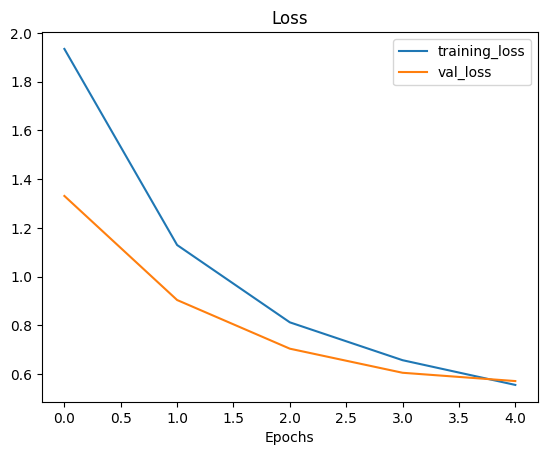

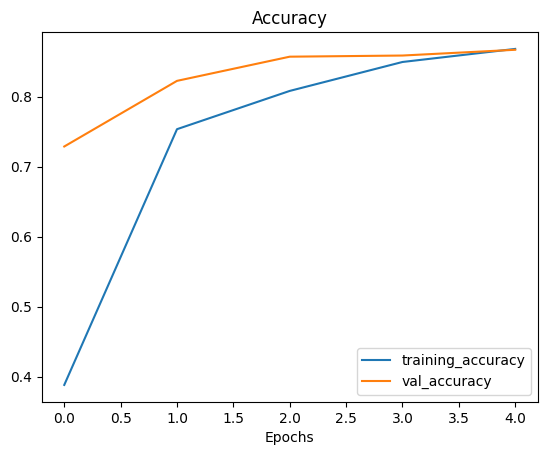

In [22]:
plot_loss_curves(history_0)

from keras.layers.pooling.global_average_pooling2d import GlobalAveragePooling2D
### Getting a feature vector

Let's demonstrate Global Average Pooling layer...

we have a tensor after out model goes through "base model" of shape (None,7,7,1280)

but then when it passes through GlobalAveragePooling2D, it turns into (None,1280)

Lets use similar shape tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D



In [23]:
input_shape=(1,4,4,3)

tf.random.set_seed(42)

input_tensor = tf.random.normal(input_shape)
print(f"Random Input Tensor:\n {input_tensor} \n")

## Pass the random tensor to a global average pooling 2d layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

print(f"global_average_pooled_tensor: {global_average_pooled_tensor}")

print(f"shape of Global Average Pooled Tensor:{global_average_pooled_tensor.shape}")

Random Input Tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 

global_average_pooled_tensor: [[-0.09368646 -0.45840448 -0.2885598 ]]
shape of Global Average Pooled Tensor:(1, 3)


In [24]:
global_average_pooled_tensor.numpy()

array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)

In [25]:
#Lets replicate Global Average Pooled 2D layer

tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

### Running a series of transfer learning experiments

We've seen the incredible reuslts of transfer learning can get with only 10% of the data, but how does it go with 1% of the training data....
how about we set up a bunch of experiments to find out:

0) Model_0 ---> base line</br>
1)  'Model_1' --> Use feature extraction transfer learning with 1% of training data with data augmentation </br>
2) "Model 2 " --> Use feature extraction transfer learning with 10% of the training with data augmentation</br>
3) "Model 3" - Use fine tuning transfer learning on 10% of the trainng data with data augmentation
4) "Model 4" --> Use finetuning transfer learning on 100% of the training data with data augmentation.

Note:  Throughout all experiments the same test dataset will be used to evaluate our model. This ensures consistency accross evalutation metrics

In [26]:
### Download and unzip data
!wget !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir ="10_food_classes_1_percent/test/"

--2023-07-02 10:00:39--  http://!wget/
Resolving !wget (!wget)... failed: Name or service not known.
wget: unable to resolve host address ‘!wget’
--2023-07-02 10:00:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.128, 74.125.69.128, 64.233.182.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  69.4MB/s    in 1.8s    

2023-07-02 10:00:41 (69.4 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]

FINISHED --2023-07-02 10:00:41--
Total wall clock time: 1.9s
Downloaded: 1 files, 127M in 1.8s (69.4 MB/s)


In [27]:
walk_through_dir("10_food_classes_1_percent")


There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There a

In [28]:
import tensorflow as tf
IMG_SIZE =(224,224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32,
                                                                          image_size=IMG_SIZE)
test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE
                                                                          )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Model 1 - Use feature extraction transfer learning with 1% data with Data Augmentation

#### Create Data Augmentation Layer

To add data augmentation into our model, we can use the layers inside:
* tf.keras.layers.experimental.preprocessing()

We can see the benefits of doing this within Tensorflow Data augmentation documentation:
"https://www.tensorflow.org/guide/keras/preprocessing_layers"

https://keras.io/guides/preprocessing_layers/


In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [30]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

ice_cream
104465.jpg


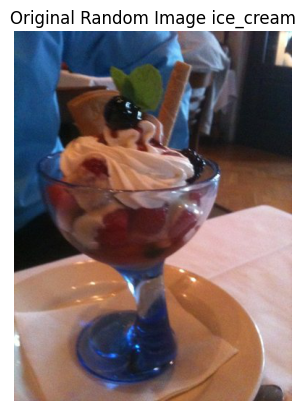

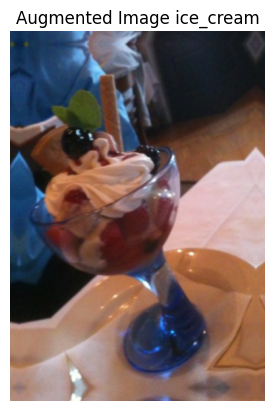

In [31]:
import matplotlib.pyplot as ptl
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
print(target_class)
target_dir = "/content/10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
print(random_image)
random_image_path =target_dir+"/"+ random_image
img = mpimg.imread(random_image_path)
plt.title(f"Original Random Image {target_class}")
plt.axis(False)
plt.imshow(img)
plt.show()

# Now let's plot our augmented random image
#print(img.shape)
augmented_img = data_augmentation(img)
plt.axis(False)
plt.title(f"Augmented Image {target_class}")
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.show()
#print(augmented_img)

### Model -1

from keras.layers.pooling.global_average_pooling2d import GlobalAveragePooling2D
* In the functional api sometimes u pass the arguement in the side and sometimes into the functions


* Note: if it is a layer we pass it outside. Below we pass the data outside the GlobalAveragePooling2D() because it is a layer

* While we pass the inputs , x in the data_augmentation because its a model we are using it as a layer

In [32]:
# Setup input shape and  base model, freezing the base model layers

input_shape =(224,224,3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable =False

# create the input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="Input Layer")

# add data augmentation sequential layer
x = data_augmentation(inputs)

x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D(name="GlobalAveragePooling2D")(x)

outputs = tf.keras.layers.Dense(10,activation="softmax",name="Output_Layer")(x)

#Create the model
model_1 = keras.Model(inputs,outputs)

#Compile the model
model_1.compile(loss="categorical_crossentropy",
                metrics=["accuracy"],
                optimizer = tf.keras.optimizers.Adam())

history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data= test_data,
                        validation_steps= int(0.25* len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name = "transfer_learning", experiment_name = "1_percent_data_Feature_Extraction")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_Feature_Extraction/20230702-100047
Epoch 1/5
3/3 [==============================] - 14s 2s/step - loss: 2.3646 - accuracy: 0.0571 - val_loss: 2.2291 - val_accuracy: 0.1842
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.0709 - accuracy: 0.3000 - val_loss: 2.1265 - val_accuracy: 0.2434
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9364 - accuracy: 0.3714 - val_loss: 2.0061 - val_accuracy: 0.3191
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.6847 - accuracy: 0.6429 - val_loss: 1.9051 - val_accuracy: 0.3701
Epoch 5/5
3/3 [==============================] - ETA: 0s - loss: 1.5433 - accuracy: 0.7286

KeyboardInterrupt: ignored

In [ ]:
model_1.summary()

In [ ]:
results_1_percent_data_aug = model_1.evaluate(test_data)

In [ ]:
results_1_percent_data_aug

In [ ]:
plot_loss_curves(history_1)

### Creating Model Checkpointing Callback

* tf.keras.callbacks.ModelCheckpoint()

ModelCheckpoint callbacks saves our model
(the full model or just the weights) during training. THis is useful so we can come and start where we left off.

In [44]:
#set checkpoint path:

checkpoint_path = "10_percent_model_checkpoints_weights/checkpoint.ckpt"

#create a modelcheckpoint callback that saves the model's weights only

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath =checkpoint_path,
                                                         save_weights_only =True,
                                                         save_best_only = False,
                                                         save_freq = "epoch",
                                                         verbose=1)




### Model2

* Preprocessing using Data augmentation layer.
*  Data - Same as model 0 ie random 10 % of training data only


In [45]:
IMG_SIZE =(224,224)

In [46]:
data_augmentation_2 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2)], name="Data_Augmentation_2")

In [47]:
train_data_10_percent_dir = "10_food_classes_10_percent/train/"
test_data_10_percent_dir = "10_food_classes_10_percent/test/"

In [48]:
train_data_10_perecent = tf.keras.preprocessing.image_dataset_from_directory( train_data_10_percent_dir,
                                                                              label_mode="categorical",
                                                                           batch_size=32,
                                                                          image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_data_10_percent_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [112]:
from keras.activations import activation_layers
input_shape = (224,224,3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=input_shape, name="Input_Layers")

x = data_augmentation_2(inputs)

x = base_model(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(10, activation="softmax", name="Output_Layers")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'],
                optimizer=tf.keras.optimizers.Adam())
initial_epoch =5
history_2 = model_2.fit(train_data_10_perecent,
                        epochs=initial_epoch,
                        steps_per_epoch = len(train_data_10_perecent),
                        validation_data = test_data,
                        validation_steps = int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback("10_food_classes_10_percent", "model_2"),checkpoint_callback])




Saving TensorBoard log files to: 10_food_classes_10_percent/model_2/20230702-104638
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9976 - accuracy: 0.3480
Epoch 1: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 298ms/step - loss: 1.9976 - accuracy: 0.3480 - val_loss: 1.4590 - val_accuracy: 0.6875
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3264 - accuracy: 0.6707
Epoch 2: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 6s 239ms/step - loss: 1.3264 - accuracy: 0.6707 - val_loss: 1.0171 - val_accuracy: 0.7862
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0192 - accuracy: 0.7640
Epoch 3: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 5s 191ms/step - loss: 1.0192 - accuracy: 0.7640 - val_loss: 0.7998 - val_accuracy: 0.8125
Epoch 4/5

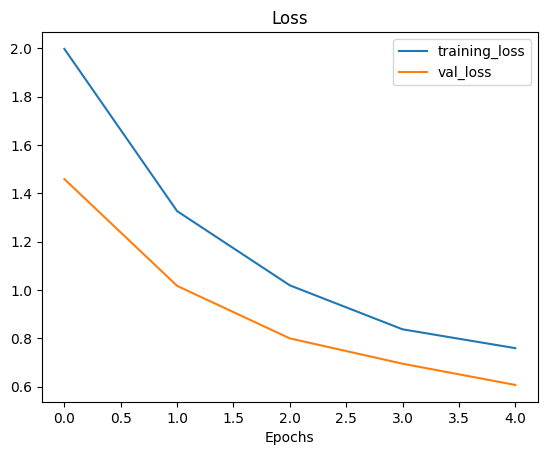

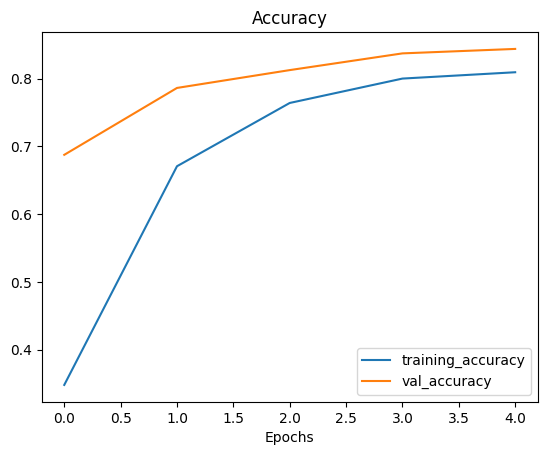

In [113]:
plot_loss_curves(history_2)

In [51]:
#model_0.evaluate(test_data)

In [52]:
results_10_percent_data_aug =model_2.evaluate(test_data)
results_10_percent_data_aug


79/79 [==============================] - 7s 82ms/step - loss: 0.6321 - accuracy: 0.8468


[0.6320722699165344, 0.8468000292778015]

In [53]:

# If the results from our native model and the loaded weights are the same, this should output True
results_1_percent_data_aug == results_10_percent_data_aug

NameError: ignored

In [ ]:
model_2.layers

In [ ]:
for layer in model_2.layers:
  print((layer, layer.trainable))

### Load the saved checkpoint weights:


In [ ]:
#model_2.weights

In [ ]:
 model_2.load_weights(checkpoint_path)

In [ ]:
model_2.evaluate(test_data)

### Model 3: Fine-tuning an existing model on 10% of the data

** Typical Pattern of Fine Tuning**

Fine Tuning usually works best *after training a feature extraction model for a few epochs with large amounts of custom data.

In [ ]:
# Layers in the loaded model

In [ ]:
for layer in model_2.layers:
  print((layer, layer.trainable))

In [ ]:
# The number of layers in base model -- EffecientNetB0
for i, layer in enumerate(model_2.layers[2].layers):
    print((i, layer, layer.trainable))

In [ ]:
### We need to unfreeze last 10 layers in the base model
## Number of trainable variables
print(len(model_2.layers[2].trainable_variables))

## TO begin fine  tuning.

Lets start by setting my last 10 layers to True

1) Set all the layers trainable to True<br>
2) then Freeze all the layers except the last layers.


In [117]:
#base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = True

In [118]:

for layer in base_model.layers[:-10]:
    layer.trainable=False

In [119]:
model_2.compile(loss="categorical_crossentropy",
                optimizer =tf.keras.optimizers.Adam(learning_rate=0.001), # when we use transfer learning we need to lower the learning rate
                metrics=["accuracy"]) #Reduce learning rate 10 time lower 0.01 to 0.001

In [120]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_11 False
1 rescaling_16 False
2 normalization_8 False
3 rescaling_17 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze F

In [121]:
print(len(model_2.trainable_variables))

12


In [59]:
finetune_epoch = initial_epoch +5
finetubne_history_2 = model_2.fit(train_data_10_perecent,
            epochs=finetune_epoch,
            steps_per_epoch=len(train_data_10_perecent),
            validation_data = test_data,
            validation_steps = int(0.25* len(test_data)),
            initial_epoch = history_2.epoch[-1],
            callbacks=[create_tensorboard_callback("transfer_learning","10_percent_fine_tuning")]) #start training from previous last epoch

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tuning/20230702-100403
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.7384 - accuracy: 0.7880
Epoch 5: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 21s 375ms/step - loss: 0.7384 - accuracy: 0.7880 - val_loss: 0.4496 - val_accuracy: 0.8470
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.3585 - accuracy: 0.8907
Epoch 6: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 7s 248ms/step - loss: 0.3585 - accuracy: 0.8907 - val_loss: 0.4193 - val_accuracy: 0.8553
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.2435 - accuracy: 0.9373
Epoch 7: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 7s 279ms/step - loss: 0.2435 - accuracy: 0.9373 - val_loss: 0.3948 - val_accuracy: 0.8783


In [60]:
model_2.evaluate(test_data)

79/79 [==============================] - 7s 79ms/step - loss: 0.4198 - accuracy: 0.8704


[0.41980770230293274, 0.8704000115394592]

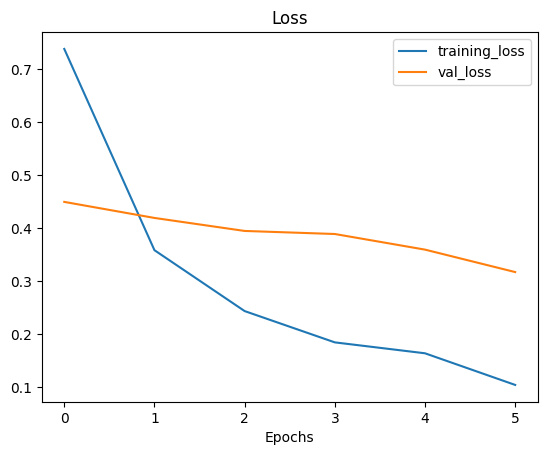

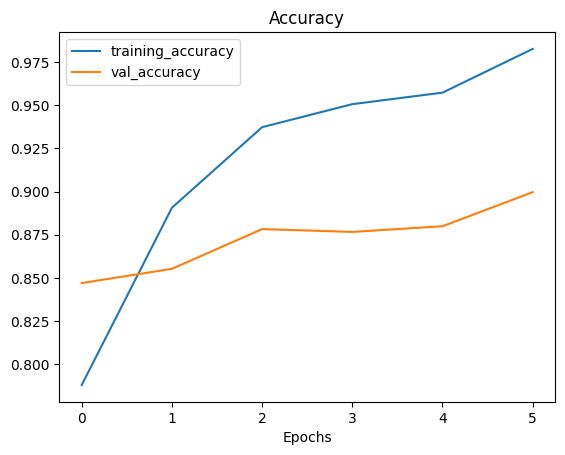

In [61]:
plot_loss_curves(finetubne_history_2)

The Plot loss curves works great with models which fit only once.

In [62]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.3306666612625122, 0.6813333630561829, 0.7400000095367432, 0.7706666588783264, 0.7973333597183228, 0.7879999876022339, 0.890666663646698, 0.937333345413208, 0.9506666660308838, 0.9573333263397217, 0.9826666712760925]


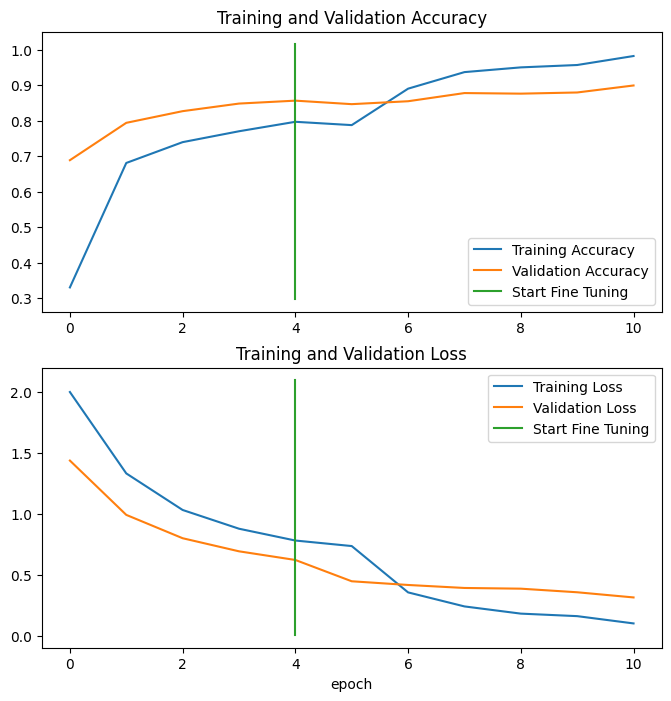

In [63]:
compare_historys(history_2,finetubne_history_2,5)

### Model 4: Fine-tuning an existing model all of the data

* 100% dataset
* Fine Tuning
* 10 Food Classes

In [64]:
! wget wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2023-07-02 10:06:47--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2023-07-02 10:06:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.128, 142.251.6.128, 108.177.112.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   193MB/s    in 2.6s    

2023-07-02 10:06:50 (193 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]

FINISHED --2023-07-02 10:06:50--
Total wall clock time: 2.7s
Downloaded: 1 files, 495M in 2.6s (193 MB/s)


In [65]:
unzip_data("10_food_classes_all_data.zip")


In [68]:
train_dir = "10_food_classes_all_data/train/"
test_dir  = "10_food_classes_10_percent/test/"

In [70]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.

#### Preprocessing the images


In [73]:
import tensorflow as tf
IMAGE_SIZE=(224,224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                batch_size=32,
                                                                 image_size=IMAGE_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode="categorical",

                                                                 image_size=IMAGE_SIZE)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [75]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 9s 101ms/step - loss: 0.4198 - accuracy: 0.8704


In [76]:
results_fine_tune_10_percent

[0.4198078215122223, 0.8704000115394592]

In [81]:
base_model.trainable=False

inputs = tf.keras.layers.Input(shape=(224,224,3))


x = data_augmentation(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(10,activation="softmax")(x)

model_4_v1 = tf.keras.Model(inputs,outputs)


In [82]:
model_4_v1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [87]:
model_4_v1.compile(loss= tf.keras.losses.CategoricalCrossentropy(),
                   optimizer="Adam",
                   metrics=['accuracy'])

In [94]:
initial_epochs=5
history_4_v1 = model_4_v1.fit(train_data,

               epochs =initial_epochs,
                              steps_per_epoch = len(train_data),
               validation_data = test_data,
               validation_steps = int(0.25*(len(test_data))),
               callbacks= [create_tensorboard_callback("transfer_learning","model_4_v1"),
                           checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/model_4_v1/20230702-102841
Epoch 1/5
235/235 [==============================] - ETA: 0s - loss: 0.4258 - accuracy: 0.8636
Epoch 1: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
235/235 [==============================] - 33s 132ms/step - loss: 0.4258 - accuracy: 0.8636 - val_loss: 0.2486 - val_accuracy: 0.9243
Epoch 2/5
235/235 [==============================] - ETA: 0s - loss: 0.4098 - accuracy: 0.8707
Epoch 2: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
235/235 [==============================] - 31s 130ms/step - loss: 0.4098 - accuracy: 0.8707 - val_loss: 0.2609 - val_accuracy: 0.9112
Epoch 3/5
235/235 [==============================] - ETA: 0s - loss: 0.3868 - accuracy: 0.8747
Epoch 3: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
235/235 [==============================] - 32s 134ms/step - loss: 0.3868 - accuracy: 0.8747 - val_loss: 0.2446 - val_accuracy: 0.9211
E

In [109]:
model_4_v1.evaluate(test_data)

79/79 [==============================] - 8s 94ms/step - loss: 0.2667 - accuracy: 0.9156


[0.2667113244533539, 0.9156000018119812]

In [106]:
base_model.trainable = True

for layer in model_4_v1.layers[2].layers[:-10]:
    layer.trainable =False


In [111]:
model_4_v1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer =tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])


In [ ]:
model_4_v1.fit(train_data_)

In [114]:
checkpoint_dir = "10_percent_model_checkpoints_weights"
latest_weights = tf.train.latest_checkpoint(checkpoint_dir)

# Note: As of TensorFlow 2.10.0+, this may error, it should work with TensorFlow 2.9.0
# See the fix here: https://github.com/mrdbourke/tensorflow-deep-learning/issues/544
model_2.load_weights(latest_weights) # revert model back to saved weights

In [115]:
model_2.evaluate(test_data)

79/79 [==============================] - 8s 89ms/step - loss: 0.6339 - accuracy: 0.8384


[0.6338956356048584, 0.8384000062942505]

Alright, the previous steps might seem quite confusing but all we've done is:

* Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using ModelCheckpoint.
* Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.
* Saved the results and training logs each time.
* Reloaded the model from 1 to do the same steps as 2 but with all of the data.

The same steps as 2?

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [122]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 Input_Layers True
1 Data_Augmentation_2 True
2 efficientnetb0 True
3 global_average_pooling2d_6 True
4 Output_Layers True


In [123]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_11 False
1 rescaling_16 False
2 normalization_8 False
3 rescaling_17 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze F

In [124]:

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])

In [125]:
fine_tune_epochs = initial_epochs+5

history_fine_10_classes_full = model_2.fit(train_data,
                                           epochs = fine_tune_epochs,
                                           initial_epoch = history_2.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps = int(0.25* len(test_data)),
                                        callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230702-105958
Epoch 5/10
235/235 [==============================] - 44s 136ms/step - loss: 0.7696 - accuracy: 0.7695 - val_loss: 0.3327 - val_accuracy: 0.8898
Epoch 6/10
235/235 [==============================] - 29s 122ms/step - loss: 0.5913 - accuracy: 0.8147 - val_loss: 0.3115 - val_accuracy: 0.8997
Epoch 7/10
235/235 [==============================] - 28s 119ms/step - loss: 0.5243 - accuracy: 0.8383 - val_loss: 0.2763 - val_accuracy: 0.9128
Epoch 8/10
235/235 [==============================] - 28s 118ms/step - loss: 0.4849 - accuracy: 0.8468 - val_loss: 0.2688 - val_accuracy: 0.9243
Epoch 9/10
235/235 [==============================] - 30s 124ms/step - loss: 0.4463 - accuracy: 0.8587 - val_loss: 0.2250 - val_accuracy: 0.9309
Epoch 10/10
235/235 [==============================] - 28s 117ms/step - loss: 0.4108 - accuracy: 0.8699 - val_loss: 0.2585 - val_accuracy: 0.9145


In [126]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)


NameError: ignored

In [131]:
!tensorboard dev upload --logdir ./transfer_learning  \
 --name "Transfer Learning Experiment with 10 Food101 Classes" \
 --description "A Series of different experiment" \
 --one_shot

2023-07-02 11:10:55.453406: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   LNGH-HRLT

gouthamans14@gmail.com


New experiment created. View your TensorBoard at: htt